In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# data preprocess tools
from nltk import data
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer

import stanza
#stanza.download('en')
nlp = stanza.Pipeline(lang='en', processors='tokenize,ner')

2021-12-02 21:27:24 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| ner       | ontonotes |

2021-12-02 21:27:24 INFO: Use device: cpu
2021-12-02 21:27:24 INFO: Loading: tokenize
2021-12-02 21:27:24 INFO: Loading: ner
2021-12-02 21:27:25 INFO: Done loading processors!


In [13]:
data = pd.read_excel('./dataset.xlsx')

In [14]:
data['content'] = data['content'].str.lower()
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
data['content'] = data['content'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))

stop_words = set(stopwords.words('english'))
stop_words.add('rt')

def text_process(text):
    tokenizer = RegexpTokenizer('[a-z0-9]+')
    token = tokenizer.tokenize(text)
    lemmatizer = WordNetLemmatizer()
    token = [lemmatizer.lemmatize(w) for w in token if lemmatizer.lemmatize(w) not in stop_words]
    return token

data['content'] = data['content'].apply(text_process)


In [343]:
X = data['content']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 211)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

non_sensitive_train = train[train['label'] == 0]
sensitive_train = train[train['label'] == 1]

# non_sensitive_train_part = non_sensitive_train['content'].sample(139, random_state=42)
# sensitive_train_part = sensitive_train['content'].sample(139, random_state=42)

non_sensitive_trainset = non_sensitive_train['content']
sensitive_trainset = sensitive_train['content']

vocablist = []

for i in pd.concat([non_sensitive_trainset, sensitive_trainset]):
    vocablist += i

trainset_texts = [' '.join(content) for content in np.concatenate((non_sensitive_trainset.values, sensitive_trainset.values))]

train_all_texts = [' '.join(content) for content in train['content']]

test_all_texts = [' '. join(content) for content in test['content']]

# trainset_texts

In [344]:
cv = CountVectorizer()
trainset_fit = cv.fit(trainset_texts)
train_all_count = cv.transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)

train_all_count

tfidf = TfidfTransformer()
train_tfidf_matrix = tfidf.fit_transform(train_all_count)
test_tfidf_matrix = tfidf.fit_transform(test_all_count)

test_all_count
# print(train_tfidf_matrix)


<129x3503 sparse matrix of type '<class 'numpy.int64'>'
	with 1336 stored elements in Compressed Sparse Row format>

In [345]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

model = MultinomialNB(alpha=1.1, fit_prior=True, class_prior=None).fit(train_tfidf_matrix, y_train)
#model.score(test_tfidf_matrix, y_test)

y_train_pdt = model.predict(train_tfidf_matrix)
y_test_pdt = model.predict(test_tfidf_matrix)

dts1 = len(np.where(y_train_pdt==y_train)[0])/len(y_train)
dts2 = len(np.where(y_test_pdt==y_test)[0])/len(y_test)

acc1 = accuracy_score(y_train_pdt, y_train)
acc2 = accuracy_score(y_test_pdt, y_test)

pre1 = precision_score(y_train_pdt, y_train)
pre2 = precision_score(y_test_pdt, y_test)

rec1 = recall_score(y_train_pdt, y_train)
rec2 = recall_score(y_test_pdt, y_test)

print("accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, dts1：{:.2f}%".format(acc1*100, pre1*100, rec1*100, dts1*100))
print("accuracy:{:.3f}%, precision:{:.3f}%, recall:{:.3f}%, dts2：{:.2f}%".format(acc2*100, pre2*100, rec2*100, dts2*100))
    

accuracy:98.062%, precision:95.495%, recall:100.000%, dts1：98.06%
accuracy:82.171%, precision:62.963%, recall:91.892%, dts2：82.17%


In [ ]:
# text = "@Alice My name is Bob, Today is my Birthday. My salary is $2000 per month, I work in Microsoft.My workmate is bad"
#text = "Today is my Birthday."
#text = "My salary is $2000 per month"
#text = "My boss Roan is a foolish man"
#text = "I hope Alice get fired tommorrow"
#text = "My workmate is nice"
#text = "My workmate is bad"
#text = "My workmate is shameless"
#text = "My employee John is good"
#text = "My employee John is good but mean"
text = "My employee John is asshole, but he pays me a lot"
#text = "my salary is $200 pounds every month"

#df = pd.read_excel('./test.xlsx')



df = pd.DataFrame({"text":text},index=["0"])

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('@')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('#')]))
df['text'] = df['text'].apply(lambda string: ' '.join([word for word in string.split(' ') if not word.rstrip(' ').startswith('http')]))
df['text'] = df['text'].apply(text_process)
#print(df['content'])


In [167]:
print(df['text'])
#y_label = df['label']
text_content = [' '.join(content) for content in df['text']]
text_count = cv.transform(text_content)
text_tfidf_matrix = tfidf.fit_transform(text_count)
                
pre = model.predict(text_tfidf_matrix)
print(pre)
#acc_test = accuracy_score(pre, y_label)
#print(acc_test)

0    [employee, john, asshole, pay, lot]
Name: text, dtype: object
[1]


Text(0, 0.5, 'tpr')

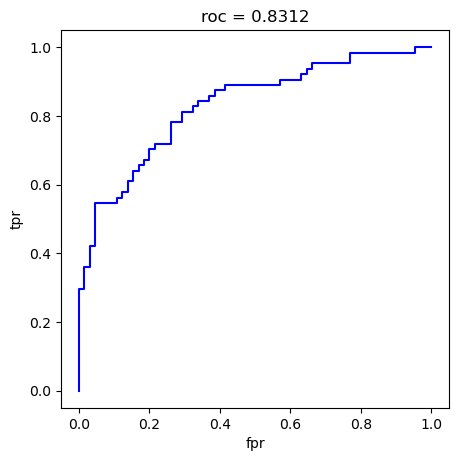

In [168]:
from sklearn import metrics
y_pred = model.predict_proba(test_tfidf_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc = metrics.auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.title('roc = {:.4f}'.format(roc_auc))
plt.xlabel('fpr')
plt.ylabel('tpr')


In [ ]:
# feature of engineering
from sklearn.feature_selection import VarianceThreshold

cv = CountVectorizer()
trainset_fit = cv.fit(trainset_texts)
train_all_count = cv.fit_transform(train_all_texts)
test_all_count = cv.transform(test_all_texts)

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
train_tfidf_matrix = sel.fit_transform(train_all_count)
test_tfidf_matrix = sel.fit_transform(test_all_count)

#test_sel
#
#tfidf = TfidfTransformer()
#train_tfidf_matrix = tfidf.fit_transform(train_sel)
#test_tfidf_matrix = tfidf.fit_transform(test_sel)

test_tfidf_matrix

In [ ]:
#
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
newData = pca.fit_transform(train_all_count)
print (newData)

pre = clf.predict(X)
Y = [1,1,0,0,1,0,0,1,1,0]
import matplotlib.pyplot as plt
L1 = [n[0] for n in newData]
L2 = [n[1] for n in newData]
plt.scatter(L1,L2,c=pre,s=200)
plt.show()

In [ ]:
# 词袋
from gensim import models
from gensim import corpora

train_word_list = []
for corpu in train_all_texts:
    seg_list = [i for i in corpu] 
    word_list.append(seg_list)

#print(word_list)

test_word_list = []
for corpu in test_all_texts:
    seg_list = [i for i in corpu] 
    test_word_list.append(seg_list)

    
train_dictionary = corpora.Dictionary(train_word_list)
test_dictionary = corpora.Dictionary(test_word_list)

#print(dictionary.token2id)
trainset = [dictionary.doc2bow(word) for word in train_word_list]
testset = [dictionary.doc2bow(word) for word in test_word_list]

train_tfidf = models.TfidfModel(trainset)
test_tfidf = models.TfidfModel(testset)

train_tfidf_vec = []
for i in trainset:
    string_tfidf = train_tfidf[i]
    train_tfidf_vec.append(string_tfidf)
print(train_tfidf_vec)


test_tfidf_vec = []
for i in testset:
    string_tfidf = test_tfidf[i]
    test_tfidf_vec.append(string_tfidf)
#print(test_tfidf_vec)